In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [31]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

In [17]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [18]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [19]:
train_images =np.reshape(train_images, (-1,28,28,1))
test_images =np.reshape(test_images, (-1,28,28,1))

In [20]:
train_images = tf.keras.layers.Concatenate()([train_images,train_images,train_images])
test_images = tf.keras.layers.Concatenate()([test_images,test_images,test_images])

train_images.shape

TensorShape([60000, 28, 28, 3])

In [21]:
resized_train_images = tf.image.resize(train_images, (32,32))
resized_test_images = tf.image.resize(test_images, (32,32))

resized_train_images.shape, train_images.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([60000, 28, 28, 3]))

In [22]:
from keras.preprocessing.image import img_to_array
train_images_mtrx = np.asarray([img_to_array(im) for im in resized_train_images])
test_images_mtrx = np.asarray([img_to_array(im) for im in resized_test_images])

In [23]:
from sklearn.model_selection import train_test_split
train_images, train_images_val, train_labels, train_labels_val = train_test_split(train_images_mtrx, train_labels, test_size=0.2, random_state=13)

In [24]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_generator = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator.fit(train_images)
test_generator.fit(train_images_val)

In [26]:
train_generator = train_generator.flow(train_images, train_labels, batch_size=200)
test_generator = test_generator.flow(train_images_val, train_labels_val, batch_size=200)

In [27]:
test_images.shape

TensorShape([10000, 28, 28, 3])

In [32]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [33]:
conv_base.trainable = False
#conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block3_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [34]:
# Створення CNN моделі

original_dim = (32, 32, 3)
target_size = (150, 150)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(original_dim))
model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [35]:
# Виведення інформації про модель
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [40]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5', verbose=1, save_best_only=True)

# Компіляція моделі
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(1e-4),
    metrics=["accuracy"]
)

In [41]:
# Тренування моделі
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=60,
    shuffle=True,
    callbacks=[checkpointer]
    )

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.7724
Epoch 1: val_loss improved from inf to 0.46175, saving model to best_weights.hdf5
100/100 [==============================] - 70s 690ms/step - loss: 0.6203 - accuracy: 0.7724 - val_loss: 0.4618 - val_accuracy: 0.8304
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7793
Epoch 2: val_loss did not improve from 0.46175
100/100 [==============================] - 68s 683ms/step - loss: 0.6052 - accuracy: 0.7793 - val_loss: 0.4901 - val_accuracy: 0.8303
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7763
Epoch 3: val_loss did not improve from 0.46175
100/100 [==============================] - 67s 674ms/step - loss: 0.6046 - accuracy: 0.7763 - val_loss: 0.5105 - val_accuracy: 0.8163
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.7804
Epoch 4: val_loss improved from 0.4617

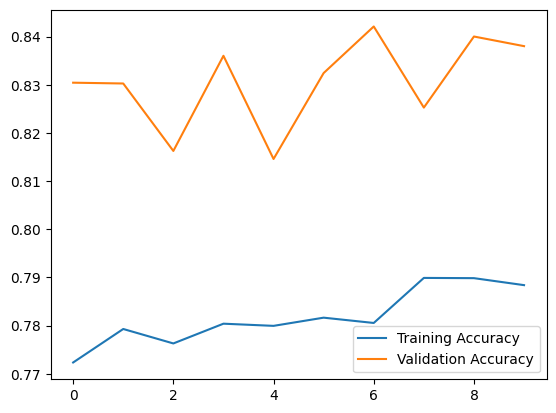

In [47]:
# Виведення графіків точності та втрат від кількості епох
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

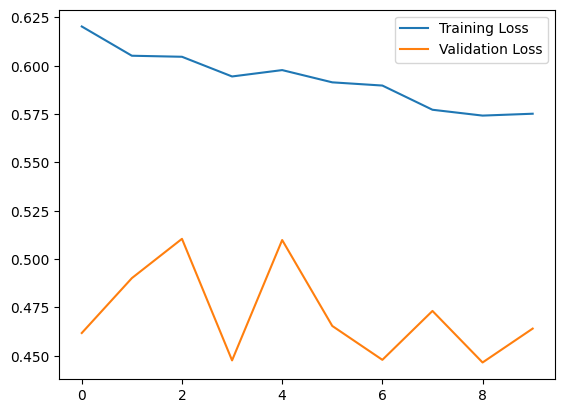

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()